In [1]:
# Load files 
import pandas as pd

orders = pd.read_csv("olist_orders_dataset.csv", 
                     usecols=["order_id","customer_id","order_purchase_timestamp",
                              "order_delivered_customer_date", 'order_approved_at', "order_estimated_delivery_date",
                              "order_status"])


order_items = pd.read_csv("olist_order_items_dataset.csv", 
                          usecols=["order_id","product_id","seller_id","price","freight_value"])


products = pd.read_csv("olist_products_dataset.csv", 
                       usecols=["product_id","product_category_name","product_weight_g",
                                "product_length_cm","product_height_cm","product_width_cm"])


sellers = pd.read_csv("olist_sellers_dataset.csv", 
                      usecols=["seller_id","seller_zip_code_prefix","seller_city","seller_state"])


customers = pd.read_csv("olist_customers_dataset.csv", 
                        usecols=["customer_id","customer_zip_code_prefix","customer_city","customer_state"])

reviews = pd.read_csv('olist_order_reviews_dataset.csv', usecols=['review_score', 'order_id'])


# Set each city to one geolocation coordinate before merging
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
city_geo = (
    geolocation
    .groupby('geolocation_city', as_index=False)
    .agg(geolocation_lat=('geolocation_lat','mean'),
         geolocation_lng=('geolocation_lng','mean'))
    .rename(columns={'geolocation_lat':'city_lat','geolocation_lng':'city_lng'})
)

# Prep two lookup tables: one for customer_city, one for seller_city
city_geo_cust = city_geo.rename(columns={
    'geolocation_city':'customer_city',
    'city_lat':'cust_lat',
    'city_lng':'cust_lng'
})
city_geo_sell = city_geo.rename(columns={
    'geolocation_city':'seller_city',
    'city_lat':'sell_lat',
    'city_lng':'sell_lng'
})




In [2]:
# Filter delivered orders

orders = orders[orders["order_status"] == "delivered"].copy()

In [3]:
# Merge all CSV's

df = orders.merge(order_items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(customers, on="customer_id", how="left")
df = df.merge(reviews, on="order_id", how="left")

df = df.merge(city_geo_cust, on='customer_city', how='left')
df = df.merge(city_geo_sell, on='seller_city',  how='left')

#df.head()

In [4]:
# Calculate distance fucntion

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [5]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

df["is_late"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

#df["is_late"].value_counts()
#df.head()

In [6]:
# Drop unnecessary columns

df = df.drop(['order_id', 'customer_id', 'order_status', 'product_id', 'seller_zip_code_prefix', 'seller_city', 'customer_zip_code_prefix', 'customer_city'], axis = 1)
#df.head()

In [7]:
# Feature Engineering 

# Introduce volume
df['item_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

# Introduce freight/price ratio
df['freight_to_price'] = df['freight_value'] / df['price']

# Grouping top 10 categories
top_10 = df["product_category_name"].value_counts().head(10).index
df["product_category_name"] = df["product_category_name"].where(
    df["product_category_name"].isin(top_10),
    "other"
)

# Grouping top 5 states
top5_customer = df['customer_state'].value_counts().nlargest(5).index
top5_seller   = df['seller_state'].value_counts().nlargest(5).index
df['customer_state'] = df['customer_state'].where(
    df['customer_state'].isin(top5_customer), 'other'
)

df['seller_state'] = df['seller_state'].where(
    df['seller_state'].isin(top5_seller), 'other'
)

# Day of week
df['order_day_week'] = df['order_purchase_timestamp'].dt.dayofweek

# Week of year
df['order_week_year'] = df['order_purchase_timestamp'].dt.isocalendar().week.astype(int)

# Introduce order at night
df['night_order'] = df["order_purchase_timestamp"].dt.hour.isin([20, 21, 22, 23, 0, 1, 2, 3, 4, 5]).astype(int)

# Introduce order approval lag (in hours)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['approval_lag_hours'] = ((df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600).round(1)

# Introduce same-state delivery
df["same_state"] = (df["seller_state"] == df["customer_state"]).astype(int)

# Introduce estimated delivery given
df['estimated_delivery_hours'] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() // 3600

# Distance
df['distance_km'] = haversine(
    df['cust_lat'], df['cust_lng'],
    df['sell_lat'], df['sell_lng']
)

# Distance/Delivery Hour ratio
df['distance_hours'] = df['distance_km'] / df['estimated_delivery_hours']

In [8]:
# Drop columns after feature engineering

df = df.drop(['product_width_cm', 'product_length_cm', 'product_height_cm'], axis = 1)
df = df.drop(['order_delivered_customer_date'], axis = 1)
df = df.drop(['order_purchase_timestamp', 'order_estimated_delivery_date', 'seller_id', 'order_approved_at'], axis = 1)
df = df.drop(['sell_lat', 'sell_lng', 'cust_lng', 'cust_lat'], axis = 1)

In [9]:
df.head()

,price,freight_value,product_category_name,product_weight_g,seller_state,customer_city,customer_state,review_score,is_late,item_volume,freight_to_price,order_day_week,order_week_year,night_order,approval_lag_hours,same_state,estimated_delivery_hours,distance_km,distance_hours
0,29.99,8.72,utilidades_domesticas,500.0,SP,sao paulo,SP,4.0,0,1976.0,0.290764,0,40,0,0.2,1,373.0,21.775806,0.058380
1,118.70,22.76,other,400.0,SP,barreiras,other,4.0,0,4693.0,0.191744,1,30,1,30.7,0,459.0,869.634254,1.894628
2,159.90,19.22,automotivo,420.0,SP,vianopolis,other,5.0,0,9576.0,0.120200,2,32,0,0.3,0,639.0,514.362214,0.804949
3,45.00,27.20,other,450.0,MG,sao goncalo do amarante,other,5.0,0,6000.0,0.604444,5,46,0,0.3,0,628.0,1841.779324,2.932770
4,19.90,8.72,other,250.0,SP,santo andre,SP,5.0,0,11475.0,0.438191,1,7,1,1.0,1,290.0,35.927669,0.123889


In [10]:
# One hot encode
columns_to_one_hot_encode = ['product_category_name','seller_state','customer_state']
df = pd.get_dummies(df, columns=columns_to_one_hot_encode, drop_first=False)
print(df.shape)

(110840, 4123)


In [11]:
# # Undersample

# from imblearn.under_sampling import RandomUnderSampler

# X = df.drop('is_late', axis=1)
# y = df['is_late']

# # sampling_strategy = desired_minority/majority ratio
# # If you want majority(0) = 2 × minority(1) → ratio = 0.5
# rus = RandomUnderSampler(sampling_strategy=0.25, random_state=42)

# X_res, y_res = rus.fit_resample(X, y)

# print(y_res.value_counts())

In [12]:
# Train test split

from sklearn.model_selection import train_test_split
X = df.drop(['is_late'], axis=1)
y = df['is_late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print(y.value_counts())

is_late
0    102085
1      8755
Name: count, dtype: int64


In [13]:
# XGBoost Baseline model

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

baseline_model = XGBClassifier(
    scale_pos_weight=11.6,   # 👈 imbalance handling
    random_state=21
)
baseline_model.fit(X_train,y_train, verbose=1)
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8361151208949837
F1: 0.41825460368294637
ROC AUC: 0.8776592351960157
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     20434
           1       0.29      0.75      0.42      1734

    accuracy                           0.84     22168
   macro avg       0.63      0.80      0.66     22168
weighted avg       0.92      0.84      0.87     22168



In [14]:
# Feature Importance check to evaluate feature engineering

# import shap

# # for tree models (RF/XGB)
# explainer = shap.TreeExplainer(baseline_model)
# shap_values = explainer.shap_values(X_test)

# # summary plot
# shap.summary_plot(shap_values, X_test)


In [15]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=21
)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)   # lower threshold to boost recall (threshold tuning)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.8065229159148322
F1: 0.3605188608916058
ROC AUC: 0.8338290074246971
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     20434
           1       0.24      0.70      0.36      1734

    accuracy                           0.81     22168
   macro avg       0.61      0.76      0.62     22168
weighted avg       0.91      0.81      0.84     22168



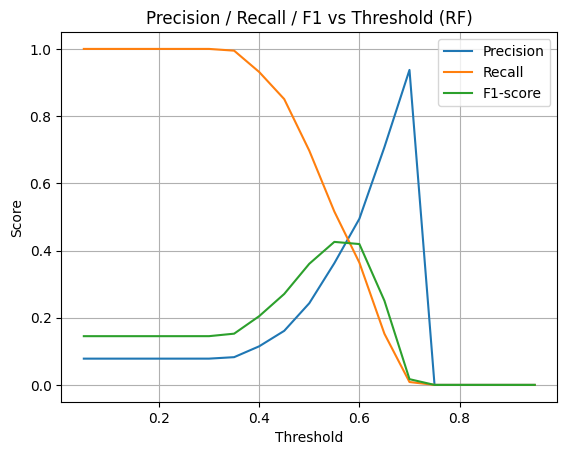

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.05, 0.95, 19)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold (RF)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# # Cross Validation

# from sklearn.model_selection import StratifiedKFold, cross_val_score
# import numpy as np

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# scores = cross_val_score(
#     clf,
#     X, y,
#     cv=cv,
#     scoring="f1"
# )

# print("F1 mean:", np.mean(scores))
# print("F1 std:", np.std(scores))

#F1 mean: 0.43077018097704106
#F1 std: 0.01434759129824481

In [18]:
# Hyperparameter tuning

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 2, 5]
# }

# grid = GridSearchCV(
#     RandomForestClassifier(class_weight="balanced", random_state=21, n_jobs=-1),
#     param_grid,
#     scoring='f1',
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# print("Best params:", grid.best_params_)
# print("Best score:", grid.best_score_)

# Best params: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 300}
# Best score: 0.4033718414064435

In [19]:
# LGM Classifier 

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# model
lgbm = LGBMClassifier(
    n_estimators=300,
    class_weight="balanced", # handle imbalance
    random_state=21,
    n_jobs=-1
)

# fit
lgbm.fit(X_train, y_train)

# predict
y_proba = lgbm.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.74).astype(int)   # adjust threshold

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
# catboost Classifier 

from catboost import CatBoostClassifier

# model
cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    class_weights=[1, 12],   # ratio ~1:12 for imbalance
    random_seed=21,
    verbose=100
)

# fit (if you have raw categoricals, pass cat_features=[list of column indices])
cat.fit(X_train, y_train)

# predict
y_proba = cat.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.65).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))